<a href="https://colab.research.google.com/github/ayush-1701/Covid19Detection/blob/main/covid19Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/COLAB/Datasets/Covid19Detection/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv3D, MaxPooling3D,GlobalAveragePooling3D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf 
from tensorflow.keras.preprocessing import image


In [5]:
DATASET = '/content/COVID-19_Radiography_Dataset'

In [6]:
os.listdir(DATASET)

['COVID.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'COVID',
 'Viral Pneumonia.metadata.xlsx',
 'Lung_Opacity.metadata.xlsx',
 'README.md.txt']

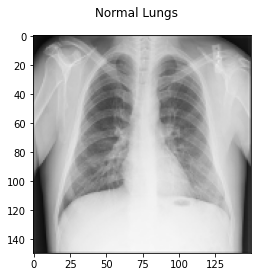

In [7]:
normal_images = []
count = 0 
for img_path in glob.glob(DATASET + "/Normal/*"):
  count = count +1
  normal_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
  if count >500:
    break
    
fig = plt.figure()
fig.suptitle("Normal Lungs")
plt.imshow(normal_images[0])
plt.show()

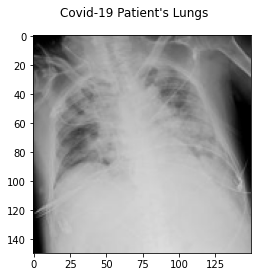

In [8]:
covid_images = []
for img_path in glob.glob(DATASET + "/COVID/*"): 
    covid_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
    
fig = plt.figure()
fig.suptitle("Covid-19 Patient's Lungs ")
plt.imshow(covid_images[0])
plt.show()

In [9]:
print(str(len(normal_images))+" normal patient images")
print(str(len(covid_images))+" covid patient images")

501 normal patient images
3616 covid patient images


In [10]:
images_together = []

for i in normal_images:
    images_together.append(img_to_array(i))
    
for i in covid_images:
    images_together.append(img_to_array(i))
    
targets = np.zeros(len(images_together))
targets[:len(normal_images)-1]=1


In [11]:
targets = np.array(targets)
print("targets: ",targets.shape)
targets = targets.reshape(-1,1)
print("new shape of targets: ",targets.shape)
images_together = np.array(images_together)

targets:  (4117,)
new shape of targets:  (4117, 1)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_together, targets, test_size=0.25, stratify=targets)

images_together = np.concatenate((X_train, X_val))
targets = np.concatenate((y_train, y_val))


In [14]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (150,150,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 48, kernel_size = (3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))
 
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 48)        13872     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        27712     
_________________________________________________________________
dense_3 (Dense)              (None, 34, 34, 1)         65        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 1)        

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)


train_generator = train_datagen.flow(
images_together, targets,
batch_size = 60,
subset = "training")

validation_generator = train_datagen.flow(
images_together, targets,
batch_size = 60,
shuffle = False,
subset = "validation")


hist = model.fit(train_generator,steps_per_epoch = (450*0.75)//30,validation_data = validation_generator,
validation_steps = (450*0.25)// 30,
epochs = 50)

Epoch 1/50
11/11 [==============================] - 20s 2s/step - loss: 0.3168 - accuracy: 0.8924 - val_loss: 0.2610 - val_accuracy: 0.9111
Epoch 2/50
11/11 [==============================] - 21s 2s/step - loss: 0.2716 - accuracy: 0.8970 - val_loss: 0.2533 - val_accuracy: 0.9111
Epoch 3/50
11/11 [==============================] - 19s 2s/step - loss: 0.2987 - accuracy: 0.8981 - val_loss: 0.2773 - val_accuracy: 0.9111
Epoch 4/50
11/11 [==============================] - 20s 2s/step - loss: 0.2835 - accuracy: 0.9030 - val_loss: 0.3014 - val_accuracy: 0.8944
Epoch 5/50
11/11 [==============================] - 20s 2s/step - loss: 0.2565 - accuracy: 0.9106 - val_loss: 0.3621 - val_accuracy: 0.8722
Epoch 6/50
11/11 [==============================] - 20s 2s/step - loss: 0.3081 - accuracy: 0.8939 - val_loss: 0.2920 - val_accuracy: 0.9111
Epoch 7/50
11/11 [==============================] - 20s 2s/step - loss: 0.2893 - accuracy: 0.9000 - val_loss: 0.2816 - val_accuracy: 0.9111
Epoch 8/50
11/11 [==

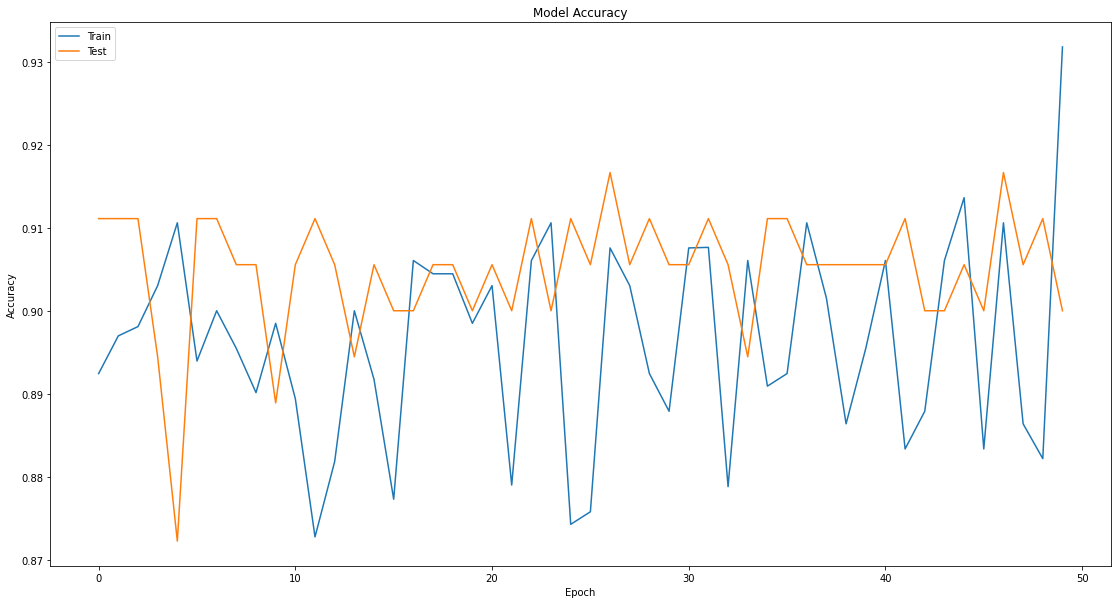

In [25]:
plt.figure(figsize = (19,10))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [26]:
print("Training Accuracy: "+str(np.round(hist.history["accuracy"][-1]*100,2))+"%")
print("Validation Accuracy: "+str(np.round(hist.history["val_accuracy"][-1]*100,2))+"%")

Training Accuracy: 93.18%
Validation Accuracy: 90.0%


In [27]:
model.save("covid_pa.h5")


In [28]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [29]:
filepath = ("/content/covid_pa.h5")

In [30]:
model = load_model(filepath, compile = True)

In [31]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [50]:
imagePath= ("/content/TEST1.jpeg")

In [55]:
from keras.preprocessing import image

test_image = image.load_img(imagePath, target_size = (150,150,3)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)


result = model.predict(test_image)
if(result[0][0] <= 1.0):
  print("Normal, No covid Detected")
else:
  print("Covid 19 Detected")

Normal, No covid Detected
